In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.tmp_dir: /Users/trafferty/tmp
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.images_root: /Users/trafferty/data/images
 paths.ws_dir: /Users/trafferty/workspace
 paths.data_root: /Users/trafferty/data
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.mii_home: /Users/trafferty/dev


### Read in an image, some anotation, plotting

In [2]:
DIF2_dots_path=paths.images_root+'/dif/DIF2_calibration_images/dots.tif'
DIF2_CB_path=paths.images_root+'/dif/DIF2_calibration_images/DIF2_checkerboard_5.tif'
DIF2_img1_path = paths.images_root+'/dif/DIF2_OCE_images/DIFCapture_01.tif'

cb1_path=paths.images_root+'/checkerboard1.png'
cb_normal_path=paths.images_root+'/checkerboard_normal.png'
cb_barrel_path=paths.images_root+'/checkerboard_barrel.png'
cb_pincushion_path=paths.images_root+'/checkerboard_pincushion.png'

cb_normal = cv2.imread(cb_normal_path,cv2.IMREAD_GRAYSCALE)
cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_pincushion = cv2.imread(cb_pincushion_path,cv2.IMREAD_GRAYSCALE)

circGrid_path = paths.images_root+'/circle_grid.jpg'
DIF2_circGrid_path = paths.images_root+'/dif/DIF2_calibration_images/62.5 um circle_mid.tif'

#default_path = DIF2_CB_path
default_path = DIF2_circGrid_path


# Scale 16-bit image to 8-bit
def convert16BitTo8Bit(img16):
    # Scale ref to 8-bit
    minLevel = np.min(np.min(img16))
    img8 = (img16 - minLevel);
    maxLevel = np.max(np.max(img8))
    img8 = (img8*255.0/maxLevel).astype(np.uint8)
    return img8

def read_image(img_path=default_path, top=True):
    cb_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    rows, cols = cb_img.shape
    midX, midY = int(cols/2), int(rows/2)
    if top:
        imgSlice = cb_img[0:midY, 0:cols] #np slice: [startY:endY, startX:endX]
    else:
        imgSlice = cb_img[midY+1:rows, 0:cols]
    return convert16BitTo8Bit(imgSlice)  

def subimage2(image, center, theta, width, height):
    #theta = np.deg2rad(theta)

    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
    s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    return cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

# img = cv2.imread('../images/owl.jpg', -1)
# print( img.shape)
# patch = subimage2(img, (110, 125), np.pi / 6.0, 100, 200)


In [3]:
plot_list = []

cb_top = read_image(img_path=DIF2_CB_path, top=True)
cb_bot = read_image(img_path=DIF2_CB_path, top=False)

# gauBlur1 = cv2.GaussianBlur(cb_img_roi,(3,3),0)
# gauBlur2 = cv2.GaussianBlur(cb_img_roi,(11,11),0)
# diffOfGau = gauBlur1-gauBlur2
# dog_med = cv2.medianBlur(diffOfGau, 5, 0)
# cb_img_roi_equ = cv2.equalizeHist(cb_img_roi)
# ret, im_thresh = cv2.threshold(cb_img_roi_equ,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

clipLimit=50
gridSize = 20

clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(gridSize,gridSize))
cl1_top = clahe.apply(cb_top)
cl1_bot = clahe.apply(cb_bot)

#cb_img_roi_equ = cv2.equalizeHist(cl1)
# gauBlur1 = cv2.GaussianBlur(cl1,(3,3),0)
# plot_list.append((gauBlur1, "gauBlur1"))
# gauBlur2 = cv2.GaussianBlur(cb_img_roi,(11,11),0)
# plot_list.append((gauBlur2, "gauBlur2"))
# diffOfGau = gauBlur1-gauBlur2
# plot_list.append((diffOfGau, "diffOfGau"))
# dog_med = cv2.medianBlur(diffOfGau, 5, 0)
# plot_list.append((dog_med, "dog_med"))
# cb_img_roi_equ = cv2.equalizeHist(cb_img_roi)
# plot_list.append((cb_img_roi_equ, "cb_img_roi_equ"))
# ret, im_thresh = cv2.threshold(cb_img_roi_equ,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot_list.append((im_thresh, "im_thresh"))

blurKernelSize = 5
tophatKernalSize = 21
minThVal = 0
maxThVal = 255
thresholdType = cv2.THRESH_BINARY+cv2.THRESH_OTSU
 
im_gray = cv2.medianBlur(cb_top, blurKernelSize, 0)
im_gray = cv2.morphologyEx(255-im_gray,cv2.MORPH_TOPHAT,np.ones([tophatKernalSize,tophatKernalSize]))
#ret, im_thresh = cv2.adaptiveThreshold(im_gray,maxValue,adaptiveMethod, thresholdType,blockSize,subConst)
ret, im_thresh = cv2.threshold(im_gray,minThVal,maxThVal,thresholdType)
plot_list.append((im_thresh, "im_thresh"))


rows, cols = img_bot.shape
print("rows: %d, cols: %d" % (rows,cols))
midX, midY = int(cols/2), int(rows/2)

# img_bot_roi = img_bot[midY-1000:midY+1000, midX-1150:midX+1150] #np slice: [startY:endY, startX:endX]
# rows, cols = img_bot_roi.shape
# print("rows: %d, cols: %d" % (rows,cols))

# # img = np.ones(img_bot_roi.shape, np.uint8)*255

# # Draw a white, filled rectangle on the mask image
# cv2.rectangle(img_bot_roi, (0,0), (200, rows), (255, 0, 255), -1)    # upper-left and lower-right corners (X, Y)
# cv2.rectangle(img_bot_roi, (0,0), (cols,200), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (cols-200, rows), (cols, 0), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (0, rows-200), (cols, rows), (255, 255, 255), -1)

top = int(0.08 * cl1.shape[0])  # shape[0] = rows
bottom = top
left = int(0.08 * cl1.shape[1])  # shape[1] = cols
right = left
borderType = cv2.BORDER_CONSTANT

value = [250, 250, 250]
cb_top_border = cv2.copyMakeBorder(cb_top, top, bottom, left, right, borderType, None, value)
cb_bot_border = cv2.copyMakeBorder(cb_bot, top, bottom, left, right, borderType, None, value)
cl1_top_border = cv2.copyMakeBorder(cl1_top, top, bottom, left, right, borderType, None, value)
cl1_bot_border = cv2.copyMakeBorder(cl1_bot, top, bottom, left, right, borderType, None, value)

print("img_bot        - rows: %d, cols: %d" % (cl1.shape[0],img_bot.shape[1]))
print("img_bot_border - rows: %d, cols: %d" % (cl1_border.shape[0],img_bot_border.shape[1]))

# plot_list.append((cb_top, "cb_top"))
# plot_list.append((cb_top_border, "cb_top_border"))
# plot_list.append((cl1_top, "cl1_top clip=%d, gridSize=%d" % (clipLimit, gridSize)))
plot_list.append((cl1_top_border, "cl1_top_border"))

# plot_list.append((cb_bot, "cb_bot"))
# plot_list.append((cb_bot_border, "cb_bot_border"))
# plot_list.append((cl1_bot, "cl1_top clip=%d, gridSize=%d" % (clipLimit, gridSize)))
plot_list.append((cl1_bot_border, "cl1_bot_border"))

#util.plot_imgs([(cb_img_roi,'cb_img_roi'), (cl1,'cl1'), (cb_img_roi_equ,'cb_img_roi_equ')], max_cols = 4)
util.plot_imgs(plot_list, max_cols = 4)

NameError: name 'img_bot' is not defined

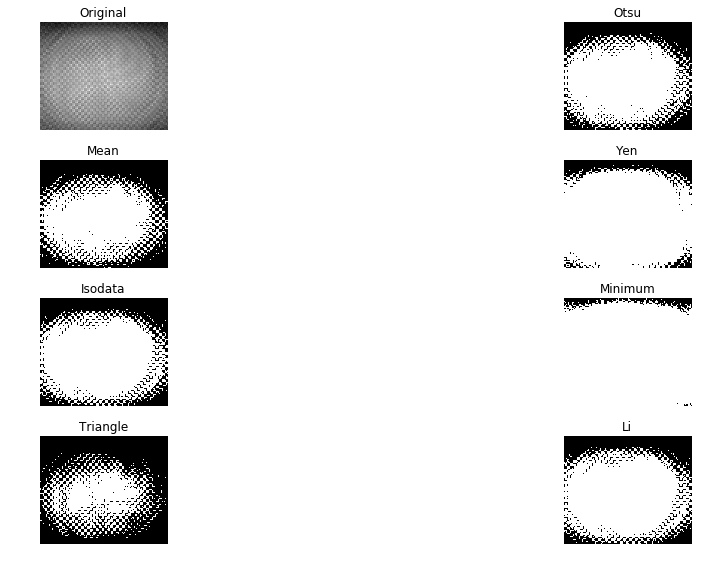

In [8]:
from skimage.filters import try_all_threshold

img = read_image(img_path=DIF2_CB_path, top=True)


# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(20, 8), verbose=False)
plt.show()

In [158]:
img_list = []
base_img = cb_top

for clipLimit in range(1, 50, 5):
    for gridSize in range(1, 100, 5):
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(gridSize,gridSize))
        cl1 = clahe.apply(cb_top)
        print("Appending image with c=%d, g=%d" % (clipLimit, gridSize))
        cl1_tup = (cl1, "c=%d_g=%d" % (clipLimit, gridSize) )
        img_list.append(cl1_tup)

Appending image with c=1, g=1
Appending image with c=1, g=6
Appending image with c=1, g=11
Appending image with c=1, g=16
Appending image with c=1, g=21
Appending image with c=1, g=26
Appending image with c=1, g=31
Appending image with c=1, g=36
Appending image with c=1, g=41
Appending image with c=1, g=46
Appending image with c=1, g=51
Appending image with c=1, g=56
Appending image with c=1, g=61
Appending image with c=1, g=66
Appending image with c=1, g=71
Appending image with c=1, g=76
Appending image with c=1, g=81
Appending image with c=1, g=86
Appending image with c=1, g=91
Appending image with c=1, g=96
Appending image with c=6, g=1
Appending image with c=6, g=6
Appending image with c=6, g=11
Appending image with c=6, g=16
Appending image with c=6, g=21
Appending image with c=6, g=26
Appending image with c=6, g=31
Appending image with c=6, g=36
Appending image with c=6, g=41
Appending image with c=6, g=46
Appending image with c=6, g=51
Appending image with c=6, g=56
Appending im

In [152]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


In [141]:
img_lst = [cb_top, cb_top_border, cl1_top, cl1_top_border, 
           cb_bot, cb_bot_border, cl1_bot, cl1_bot_border]
#patternSize = (34,40)

patternSize = (34,40)

#flags= cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK 
#flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS
flags= cv2.CALIB_CB_FAST_CHECK

for idx, img in enumerate(img_lst):
    print("Trying img# %d with pattern: (%d, %d)" % (idx, patternSize[0], patternSize[1]))

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(img, patternSize, flags)

    # If found, add object points, image points (after refining them)
    if ret == True:
        print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
    else:
        print("Not Found...")


Trying img# 0 with pattern: (34, 40)
Not Found...
Trying img# 1 with pattern: (34, 40)
Not Found...
Trying img# 2 with pattern: (34, 40)
Not Found...
Trying img# 3 with pattern: (34, 40)
Not Found...
Trying img# 4 with pattern: (34, 40)
Not Found...
Trying img# 5 with pattern: (34, 40)
Not Found...
Trying img# 6 with pattern: (34, 40)
Not Found...
Trying img# 7 with pattern: (34, 40)
Not Found...


In [161]:
plot_list = []

nominalPatternSize = (34,37)
_range = 6

for idx, img_tup in enumerate(img_list):
    rows, cols = img_tup[0].shape
    midX, midY = int(cols/2), int(rows/2)

    flags= cv2.CALIB_CB_FAST_CHECK

    for r in range((nominalPatternSize[0]-int(_range/2)), (nominalPatternSize[0]+int(_range/2))):
        for c in range((nominalPatternSize[1]-int(_range/2)), (nominalPatternSize[1]+int(_range/2))):
            patternSize = (r,c)
            print("Trying %s with pattern: (%d, %d)" % (img_tup[1], patternSize[0], patternSize[1]))

            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(img_tup[0], patternSize, flags)

            # If found, add object points, image points (after refining them)
            if ret == True:
                print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
                #objpoints.append(objp)

                corners2 = cv2.cornerSubPix(img_tup[0], corners,(11,11),(-1,-1),criteria)
                #imgpoints.append(corners2)

                # Draw and display the corners
                img2 = img_tup[0].copy()
                cv2.drawChessboardCorners(img2, patternSize, corners2,ret);

                plot_list.append((img2, img_tup[1]))

            else:
                print("Not Found...")


util.plot_imgs(plot_list, max_cols = 4)

Trying c=1_g=1 with pattern: (31, 37)
Not Found...
Trying c=1_g=1 with pattern: (31, 38)
Not Found...
Trying c=1_g=1 with pattern: (31, 39)
Not Found...
Trying c=1_g=1 with pattern: (31, 40)
Not Found...
Trying c=1_g=1 with pattern: (31, 41)
Not Found...
Trying c=1_g=1 with pattern: (31, 42)
Not Found...
Trying c=1_g=1 with pattern: (32, 37)
Not Found...
Trying c=1_g=1 with pattern: (32, 38)
Not Found...
Trying c=1_g=1 with pattern: (32, 39)
Not Found...
Trying c=1_g=1 with pattern: (32, 40)
Not Found...
Trying c=1_g=1 with pattern: (32, 41)
Not Found...
Trying c=1_g=1 with pattern: (32, 42)
Not Found...
Trying c=1_g=1 with pattern: (33, 37)
Not Found...
Trying c=1_g=1 with pattern: (33, 38)
Not Found...
Trying c=1_g=1 with pattern: (33, 39)
Not Found...
Trying c=1_g=1 with pattern: (33, 40)
Not Found...
Trying c=1_g=1 with pattern: (33, 41)
Not Found...
Trying c=1_g=1 with pattern: (33, 42)
Not Found...
Trying c=1_g=1 with pattern: (34, 37)
Not Found...
Trying c=1_g=1 with pattern: (3

Not Found...
Trying c=1_g=21 with pattern: (33, 41)
Not Found...
Trying c=1_g=21 with pattern: (33, 42)
Not Found...
Trying c=1_g=21 with pattern: (34, 37)
Not Found...
Trying c=1_g=21 with pattern: (34, 38)
Not Found...
Trying c=1_g=21 with pattern: (34, 39)
Not Found...
Trying c=1_g=21 with pattern: (34, 40)
Not Found...
Trying c=1_g=21 with pattern: (34, 41)
Not Found...
Trying c=1_g=21 with pattern: (34, 42)
Not Found...
Trying c=1_g=21 with pattern: (35, 37)
Not Found...
Trying c=1_g=21 with pattern: (35, 38)
Not Found...
Trying c=1_g=21 with pattern: (35, 39)
Not Found...
Trying c=1_g=21 with pattern: (35, 40)
Not Found...
Trying c=1_g=21 with pattern: (35, 41)
Not Found...
Trying c=1_g=21 with pattern: (35, 42)
Not Found...
Trying c=1_g=21 with pattern: (36, 37)
Not Found...
Trying c=1_g=21 with pattern: (36, 38)
Not Found...
Trying c=1_g=21 with pattern: (36, 39)
Not Found...
Trying c=1_g=21 with pattern: (36, 40)
Not Found...
Trying c=1_g=21 with pattern: (36, 41)
Not Found...

Not Found...
Trying c=1_g=41 with pattern: (36, 37)
Not Found...
Trying c=1_g=41 with pattern: (36, 38)
Not Found...
Trying c=1_g=41 with pattern: (36, 39)
Not Found...
Trying c=1_g=41 with pattern: (36, 40)
Not Found...
Trying c=1_g=41 with pattern: (36, 41)
Not Found...
Trying c=1_g=41 with pattern: (36, 42)
Not Found...
Trying c=1_g=46 with pattern: (31, 37)
Not Found...
Trying c=1_g=46 with pattern: (31, 38)
Not Found...
Trying c=1_g=46 with pattern: (31, 39)
Not Found...
Trying c=1_g=46 with pattern: (31, 40)
Not Found...
Trying c=1_g=46 with pattern: (31, 41)
Not Found...
Trying c=1_g=46 with pattern: (31, 42)
Not Found...
Trying c=1_g=46 with pattern: (32, 37)
Not Found...
Trying c=1_g=46 with pattern: (32, 38)
Not Found...
Trying c=1_g=46 with pattern: (32, 39)
Not Found...
Trying c=1_g=46 with pattern: (32, 40)
Not Found...
Trying c=1_g=46 with pattern: (32, 41)
Not Found...
Trying c=1_g=46 with pattern: (32, 42)
Not Found...
Trying c=1_g=46 with pattern: (33, 37)
Not Found...

Not Found...
Trying c=1_g=66 with pattern: (32, 39)
Not Found...
Trying c=1_g=66 with pattern: (32, 40)
Not Found...
Trying c=1_g=66 with pattern: (32, 41)
Not Found...
Trying c=1_g=66 with pattern: (32, 42)
Not Found...
Trying c=1_g=66 with pattern: (33, 37)
Not Found...
Trying c=1_g=66 with pattern: (33, 38)
Not Found...
Trying c=1_g=66 with pattern: (33, 39)
Not Found...
Trying c=1_g=66 with pattern: (33, 40)
Not Found...
Trying c=1_g=66 with pattern: (33, 41)
Not Found...
Trying c=1_g=66 with pattern: (33, 42)
Not Found...
Trying c=1_g=66 with pattern: (34, 37)
Not Found...
Trying c=1_g=66 with pattern: (34, 38)
Not Found...
Trying c=1_g=66 with pattern: (34, 39)
Not Found...
Trying c=1_g=66 with pattern: (34, 40)
Not Found...
Trying c=1_g=66 with pattern: (34, 41)
Not Found...
Trying c=1_g=66 with pattern: (34, 42)
Not Found...
Trying c=1_g=66 with pattern: (35, 37)
Not Found...
Trying c=1_g=66 with pattern: (35, 38)
Not Found...
Trying c=1_g=66 with pattern: (35, 39)
Not Found...

KeyboardInterrupt: 

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cb_img_rotated.shape[::-1],None,None)


In [ ]:
h,  w = cb_img_rotated.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [ ]:
cb_img_in = read_image(img_path=default_path, top=False)
cb_img_raw = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)


# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(cb_img_raw, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(cb_img_raw,'cb_img_raw'), (cb_img_fixed,'cb_img_fixed'), (cb_normal,'cb_normal')], max_cols = 3)

In [ ]:
idx = 1
DIF2_path = paths.images_root+'/dif/DIF2_OCE_images/DIFCapture_0%d.tif' % (idx)

dif_img_raw = cv2.imread(DIF2_path, cv2.IMREAD_GRAYSCALE)
rows, cols = dif_img_raw.shape
midX, midY = int(cols/2), int(rows/2)
print(rows/2)

dif_img = dif_img_raw[1:int(rows/2), 1:cols]  #np slice: [startY:endY, startX:endX]

util.plot_imgs([(dif_img,'dif_img')], max_cols = 3)

In [ ]:
rows, cols = dif_img.shape

cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_barrel_rotate = imutils.rotate_bound(cb_barrel, 90)
cb_barrel_large = cv2.resize(cb_barrel_rotate, (cols, rows))

for img in [dif_img, cb_barrel, cb_barrel_large]:
    print("(%d, %d)" % (img.shape[0], img.shape[1]))
    
util.plot_imgs([(cb_barrel,'cb_barrel'), (cb_barrel_rotate,'cb_barrel_rotate'), (cb_barrel_large,'cb_barrel_large')], max_cols = 3)

In [ ]:
cb_img = cb_barrel_large

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(cb_img, (7,7), None)

# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(cb_img, corners,(11,11),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    cb_img2 = cv2.drawChessboardCorners(cb_img, (7,7), corners2,ret)

    util.plot_imgs([(cb_img2,'checkerboard')], max_cols = 2)
else:
    print("Not Found...")


In [ ]:
# undistort
dst = cv2.remap(dif_img, mapx, mapy, cv2.INTER_LINEAR)

# # crop the image
# x,y,w,h = roi
# cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(dif_img,'dif_img'), (dst,'dif_img')], max_cols = 3)

### Okay, lets try findCircleGrid...

- https://longervision.github.io/2017/03/13/opencv-external-posture-estimation-circle-grid/
- https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=findchessboardcorners#findcirclesgrid


uint8
rows: 2159, cols: 2560
img_bot        - rows: 2159, cols: 2560
img_bot_border - rows: 2373, cols: 2816


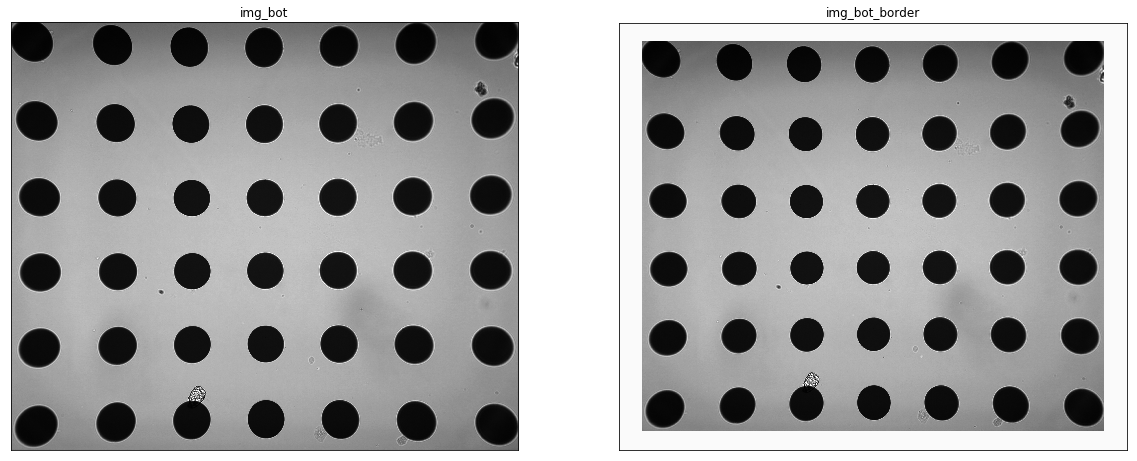

In [217]:
img_bot = read_image(img_path=DIF2_circGrid_path, top=False)
print(img_bot.dtype)
circGrid = cv2.imread(circGrid_path,cv2.IMREAD_GRAYSCALE)

rows, cols = img_bot.shape
print("rows: %d, cols: %d" % (rows,cols))
midX, midY = int(cols/2), int(rows/2)

# img_bot_roi = img_bot[midY-1000:midY+1000, midX-1150:midX+1150] #np slice: [startY:endY, startX:endX]
# rows, cols = img_bot_roi.shape
# print("rows: %d, cols: %d" % (rows,cols))

# # img = np.ones(img_bot_roi.shape, np.uint8)*255

# # Draw a white, filled rectangle on the mask image
# cv2.rectangle(img_bot_roi, (0,0), (200, rows), (255, 0, 255), -1)    # upper-left and lower-right corners (X, Y)
# cv2.rectangle(img_bot_roi, (0,0), (cols,200), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (cols-200, rows), (cols, 0), (255, 255, 255), -1)
# cv2.rectangle(img_bot_roi, (0, rows-200), (cols, rows), (255, 255, 255), -1)

top = int(0.05 * img_bot.shape[0])  # shape[0] = rows
bottom = top
left = int(0.05 * img_bot.shape[1])  # shape[1] = cols
right = left
borderType = cv2.BORDER_CONSTANT

value = [250, 250, 250]
img_bot_border = cv2.copyMakeBorder(img_bot, top, bottom, left, right, borderType, None, value)

print("img_bot        - rows: %d, cols: %d" % (img_bot.shape[0],img_bot.shape[1]))
print("img_bot_border - rows: %d, cols: %d" % (img_bot_border.shape[0],img_bot_border.shape[1]))


util.plot_imgs([(img_bot,'img_bot'), (img_bot_border,'img_bot_border')], max_cols = 3)

[findROI] num keypoints found:  42
[findROI] (255, 2145), dia: 209, area: 656.592865
[findROI] (1025, 232), dia: 194, area: 609.468975
[findROI] (1779, 227), dia: 197, area: 618.893753
[findROI] (639, 222), dia: 200, area: 628.318531
[findROI] (2167, 212), dia: 203, area: 637.743309
[findROI] (2575, 192), dia: 210, area: 659.734457
[findROI] (232, 202), dia: 209, area: 656.592865
[findROI] (2575, 2137), dia: 211, area: 662.876050
[findROI] (657, 2125), dia: 199, area: 625.176938
[findROI] (2170, 2120), dia: 200, area: 628.318531
[findROI] (1787, 2111), dia: 193, area: 606.327382
[findROI] (1413, 2110), dia: 189, area: 593.761012
[findROI] (1040, 2108), dia: 210, area: 659.734457
[findROI] (270, 1750), dia: 203, area: 637.743309
[findROI] (2555, 1741), dia: 203, area: 637.743309
[findROI] (664, 1740), dia: 193, area: 606.327382
[findROI] (2158, 1734), dia: 195, area: 612.610567
[findROI] (1780, 1730), dia: 190, area: 596.902604
[findROI] (1041, 1733), dia: 187, area: 587.477826
[findROI

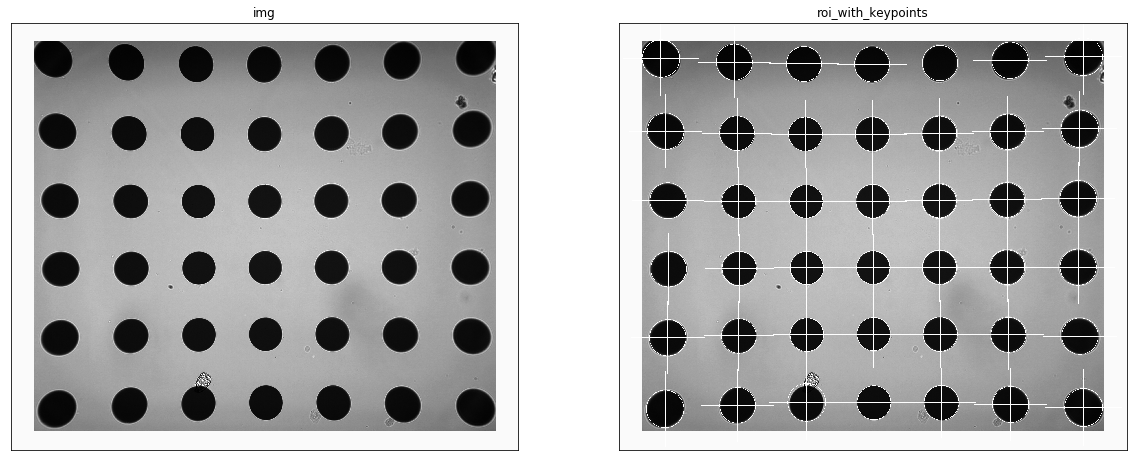

In [318]:
def createDetector():
#     # Setup SimpleBlobDetector parameters.
#     params = cv2.SimpleBlobDetector_Params()

#     # Change thresholds
#     params.minThreshold = 8 #20;
#     params.maxThreshold = 255 #35

#     # Filter by Circularity
#     params.filterByCircularity = True
#     params.minCircularity = .8

#     # # Filter by Convexity
#     params.filterByConvexity = False
#     # params.minConvexity = 0.87

#     # # Filter by Inertia
#     params.filterByInertia = False
#     # params.minInertiaRatio = 0.9

#     params.filterByColor = True
#     params.blobColor = 0
    
#     params.filterByArea = True
# #     params.minArea = 4 * np.pi
# #     params.maxArea = 100 * np.pi
#     params.minArea = 10
#     params.maxArea = 500

    blobParams = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    blobParams.minThreshold = 8
    blobParams.maxThreshold = 255

    # Filter by Area.
    blobParams.filterByArea = True
    blobParams.minArea = 20000     # minArea may be adjusted to suit for your experiment
    blobParams.maxArea = 40000   # maxArea may be adjusted to suit for your experiment

    # Filter by Circularity
    blobParams.filterByCircularity = False
    blobParams.minCircularity = 0.1

    # Filter by Convexity
    blobParams.filterByConvexity = True
    blobParams.minConvexity = 0.87

    # Filter by Inertia
    blobParams.filterByInertia = True
    blobParams.minInertiaRatio = 0.01

    blobParams.filterByColor = True
    blobParams.blobColor = 0
    
    # Create the iteration criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)    
    
    return cv2.SimpleBlobDetector_create(blobParams)

def findBLOBs(img):

    detector = createDetector()
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

# img = img_bot_roi
img = img_bot_border

keypoints = findBLOBs(img)
print( "[findROI] num keypoints found: ", len(keypoints))

drawSelf = True
if len(keypoints) > 0:
    
    foo = np.zeros((42,1,2), dtype='float32')
    
    if drawSelf:
        roi_with_keypoints = img.copy()
        for idx, kp in enumerate(keypoints):
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            
            foo[idx,0,0] = x
            foo[idx,0,1] = y
            
            if dia < 100 or dia > 250:
                print("Skipping #%d: dia = %d" % (idx, dia))
                continue

            #print(kp.size)
            print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

            cv2.circle(roi_with_keypoints, (x, y), int(dia/2), (255,255,255),2)
            cv2.line(roi_with_keypoints, (x, y-dia), (x, y+dia), (255,255,255), 3)
            cv2.line(roi_with_keypoints, (x-dia, y), (x+dia, y), (255,255,255), 3)
            
    else:
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        roi_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


    util.plot_imgs([(img,'img'), (roi_with_keypoints,'roi_with_keypoints')], max_cols = 3)


In [219]:
dot_rows = 6
dot_cols = 7

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((dot_cols*dot_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:dot_rows,0:dot_cols].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [ ]:
patternSize = (dot_rows,dot_cols)

flags = None
flags = cv2.CALIB_CB_SYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING
#flags = cv2.CALIB_CB_SYMMETRIC_GRID

retval, centers = cv2.findCirclesGrid(img_bot_border, patternSize, None, flags, createDetector())

#     im_with_keypoints_gray = cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2GRAY)
#     retval, corners = cv2.findCirclesGrid(im_with_keypoints, (4,11), None, flags = cv2.CALIB_CB_ASYMMETRIC_GRID)   # Find the circle grid


# If found, add object points, image points (after refining them)
if retval == True:
    print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
    
    objpoints.append(objp)
    
    centers2 = cv2.cornerSubPix(img_bot_border, centers,(11,11),(-1,-1),criteria)
    imgpoints.append(centers2)

    img2 = img_bot_border.copy()
    cv2.drawChessboardCorners(img2, patternSize, centers2, retval);
    
    util.plot_imgs([(img2,'img_bot_border')])
else:
    print("Not Found...")

[  255.  1025.  1779.   639.  2167.  2575.   232.  2575.   657.  2170.
  1787.  1413.  1040.   270.  2555.   664.  2158.  1780.  1041.  1411.
  1776.   275.   666.  1041.  2152.  2545.  1775.  1038.   663.   271.
  2151.  2545.  1404.  1033.  1775.   654.  2155.   258.  2554.  1402.
  1409.  1406.]
[ 2145.   232.   227.   222.   212.   192.   202.  2137.  2125.  2120.
  2111.  2110.  2108.  1750.  1741.  1740.  1734.  1730.  1733.  1730.
  1360.  1369.  1366.  1363.  1359.  1359.   991.   994.   994.   990.
   986.   979.   621.   621.   617.   616.   608.   605.   592.   234.
  1361.   993.]
[ 2579.93359375  2545.79345703  2544.13085938  2545.59716797  2562.6171875
  2584.96728516  2167.10083008  2155.67285156  2158.88842773  2156.3203125
  2162.33862305  2166.72290039  1771.1348877   1774.65551758  1781.25109863
  1778.15600586  1786.60461426  1784.08618164  1402.72180176  1404.81848145
  1399.14624023  1409.01013184  1406.71472168  1405.95336914  1020.55718994
  1036.9987793   1033.

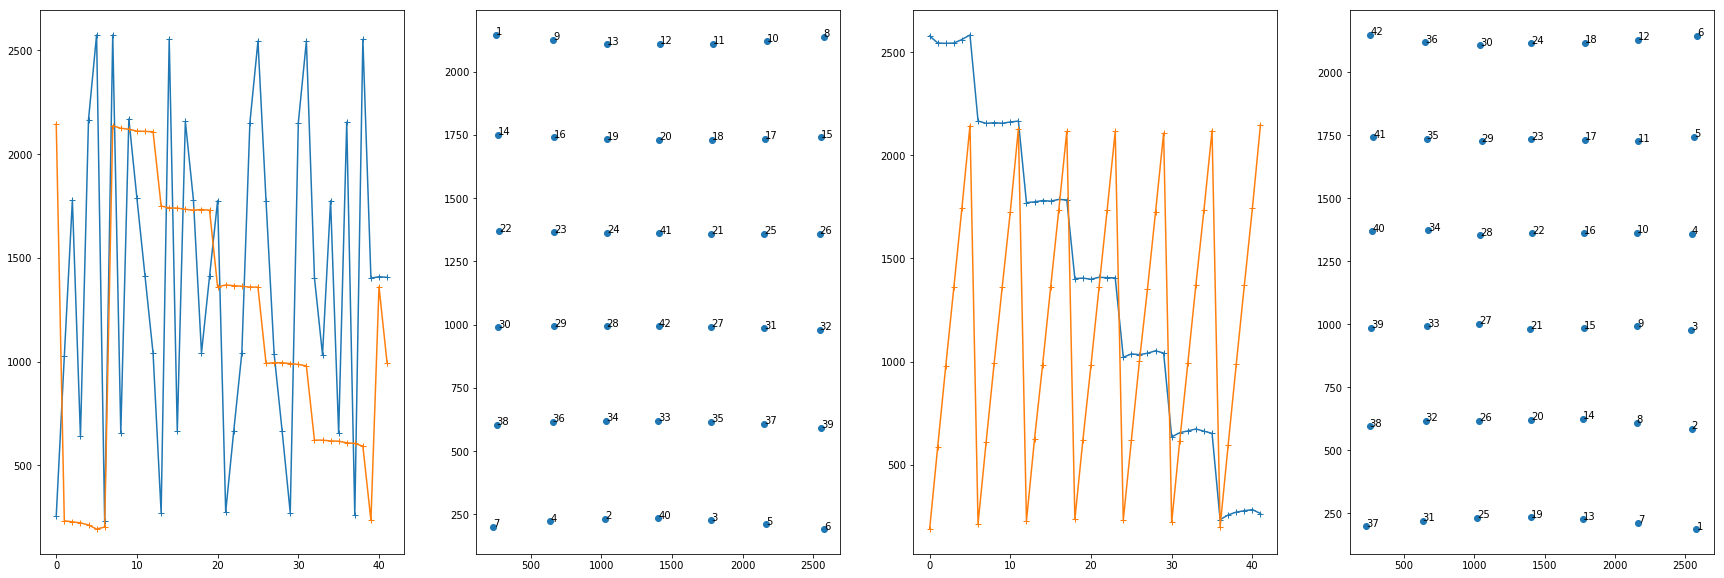

In [320]:
#foo = np.zeros((42,1,2), dtype='float32')
#f2 = foo.sort(axis=2)
# print(foo)
# print(centers)
# print(centers2)
print(foo[:,0,0])
print(foo[:,0,1])
print(centers2[:,0,0])
print(centers2[:,0,1])

foo2 = np.copy(foo)
foo2.sort(axis=2)

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

#plt.hist(centers2.ravel(), bins=range(0,13))
# ax1.hist(foo.ravel())
# ax2.hist(centers2.ravel())

ax1.plot(foo[:,0,:], marker='+')
ax2.scatter(foo[:,0,0], foo[:,0,1])

ax3.plot(centers2[:,0,:], marker='+')
ax4.scatter(centers2[:,0,0], centers2[:,0,1])

for idx in range(42):
    ax2.annotate(str(idx+1), (foo[idx,0,0], foo[idx,0,1]) )
    ax4.annotate(str(idx+1), (centers2[idx,0,0], centers2[idx,0,1]) )
    #ax4.text( foo[idx,0,0], foo[idx,0,1], str(idx+1) )
    print("(%f, %f) = %s" % (foo[idx,0,0], foo[idx,0,1], str(idx+1)))
# Show the plot
plt.show()

In [226]:
a=np.array([[1,4], [3,1]])
a.sort()
a

array([[1, 4],
       [1, 3]])

In [327]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_bot_border.shape[::-1],None,None)
rvecs

[array([[-2.66388305],
        [-0.11399414],
        [-1.17319528]])]

In [101]:
rvecs2 = [np.array([[ 0.13079631],
        [ 0.07100583],
        [ 1.56323365]])]


rvecs2 = [np.array(cam_calib['rvecs'])]
rvecs2

[array([[ 0.13079631],
        [ 0.07100583],
        [ 1.56323365]])]

In [106]:
cam_calib = {}
cam_calib['ret'] = ret
cam_calib['mtx'] = mtx.tolist()
cam_calib['dist'] = dist.tolist()
cam_calib['rvecs'] = rvecs[0].tolist()
cam_calib['tvecs'] = tvecs[0].tolist()

with open(paths.tmp_dir + '/DIF2_cam_calib.json', 'w') as outfile:
    json.dump(cam_calib, outfile)

imgSlice - rows: 2159, cols: 2560
dst      - rows: 2033, cols: 2449


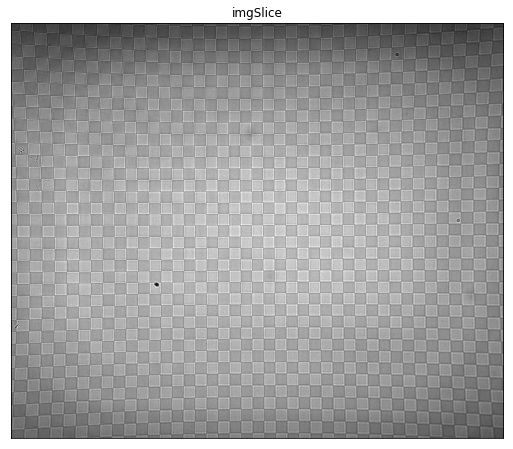

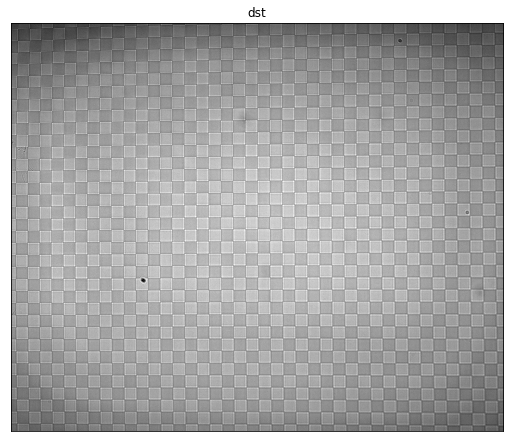

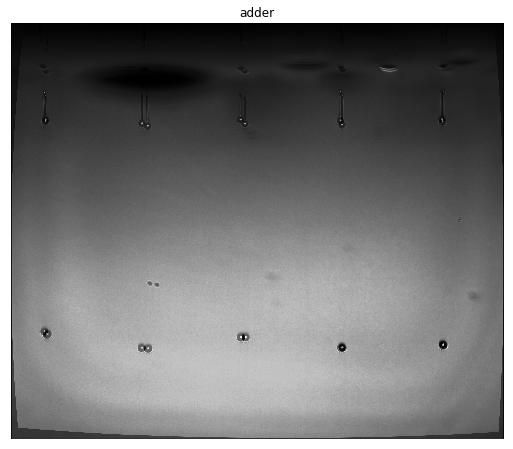

In [120]:
#p = DIF2_circGrid_path
p = DIF2_img1_path
p = cb_DIF2_path
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
img_equ = cv2.equalizeHist(img)
img_equ = img
rows, cols = img.shape
midX, midY = int(cols/2), int(rows/2)
imgSlice = img_equ[midY+1:rows, 0:cols]
img8 = convert16BitTo8Bit(imgSlice)  

with open(paths.tmp_dir + '/DIF2_cam_calib.json') as cam_calib_file:
    cam_calib2 = json.load(cam_calib_file)

mtx2 = np.array(cam_calib2['mtx'])
dist2 = np.array(cam_calib2['dist'])

h,  w = img8.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx2,dist2,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(img8, mtx2, dist2, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

print("imgSlice - rows: %d, cols: %d" % (imgSlice.shape[0],imgSlice.shape[1]))
print("dst      - rows: %d, cols: %d" % (dst.shape[0],dst.shape[1]))

#adder = cv2.addWeighted(img8,0.5,dst,0.5,0)

util.plot_imgs([(imgSlice,'imgSlice'), (dst,'dst'), (adder,'adder')], max_cols = 1)

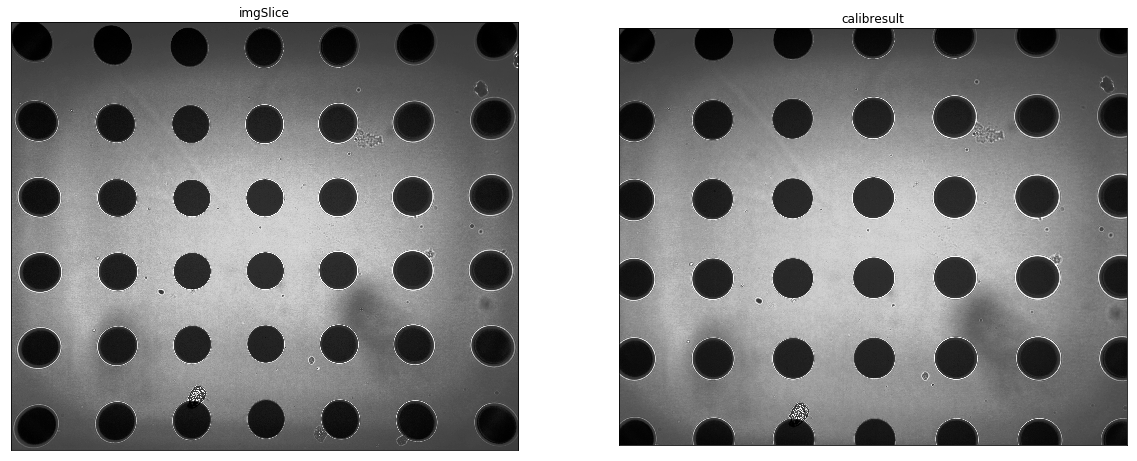

In [108]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx2,dist2,None,newcameramtx,(w,h),5)
dst2 = cv2.remap(img8,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst2 = dst2[y:y+h, x:x+w]
util.plot_imgs([(imgSlice,'imgSlice'), (dst2,'calibresult')], max_cols = 2)

### Lets try Qi's Dots

Dots: rows: 1844, cols: 2560


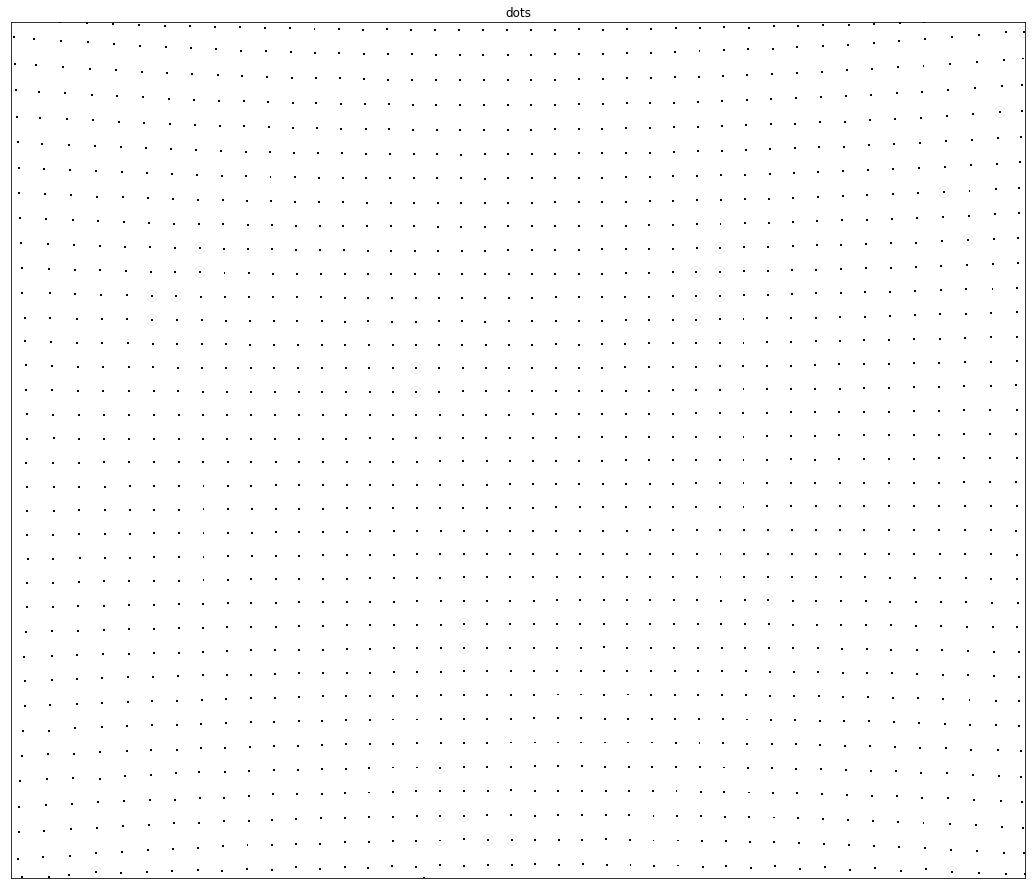

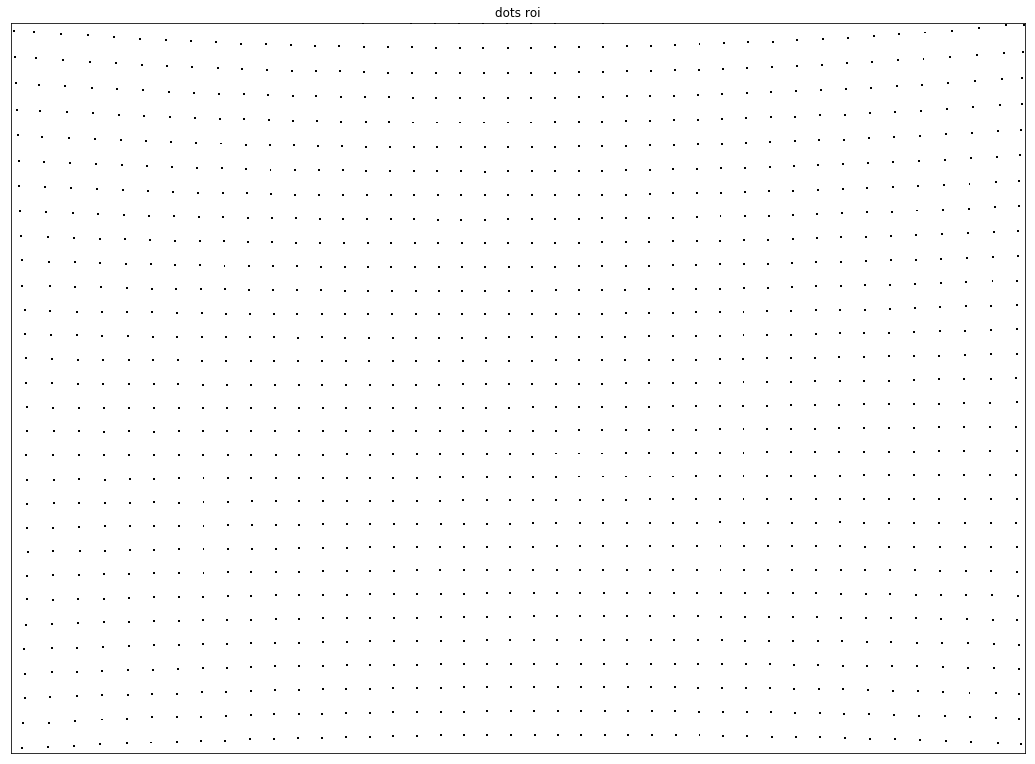

In [200]:
dots = cv2.imread(DIF2_dots_path,cv2.IMREAD_GRAYSCALE)

dots_roi = dots[20:rows-25, 0:cols].copy() #np slice: [startY:endY, startX:endX]

rows, cols = dots_roi.shape
print("Dots: rows: %d, cols: %d" % (rows,cols))
midX, midY = int(cols/2), int(rows/2)

cv2.rectangle(dots_roi, (int(cols*.2), rows-15), (int(cols*.8), rows), (255, 255, 255), -1)  # upper-left and lower-right corners (X, Y)

util.plot_imgs([(dots,'dots'), (dots_roi,'dots roi')], max_cols = 1, fig_size=20)

[findROI] num keypoints found:  1260


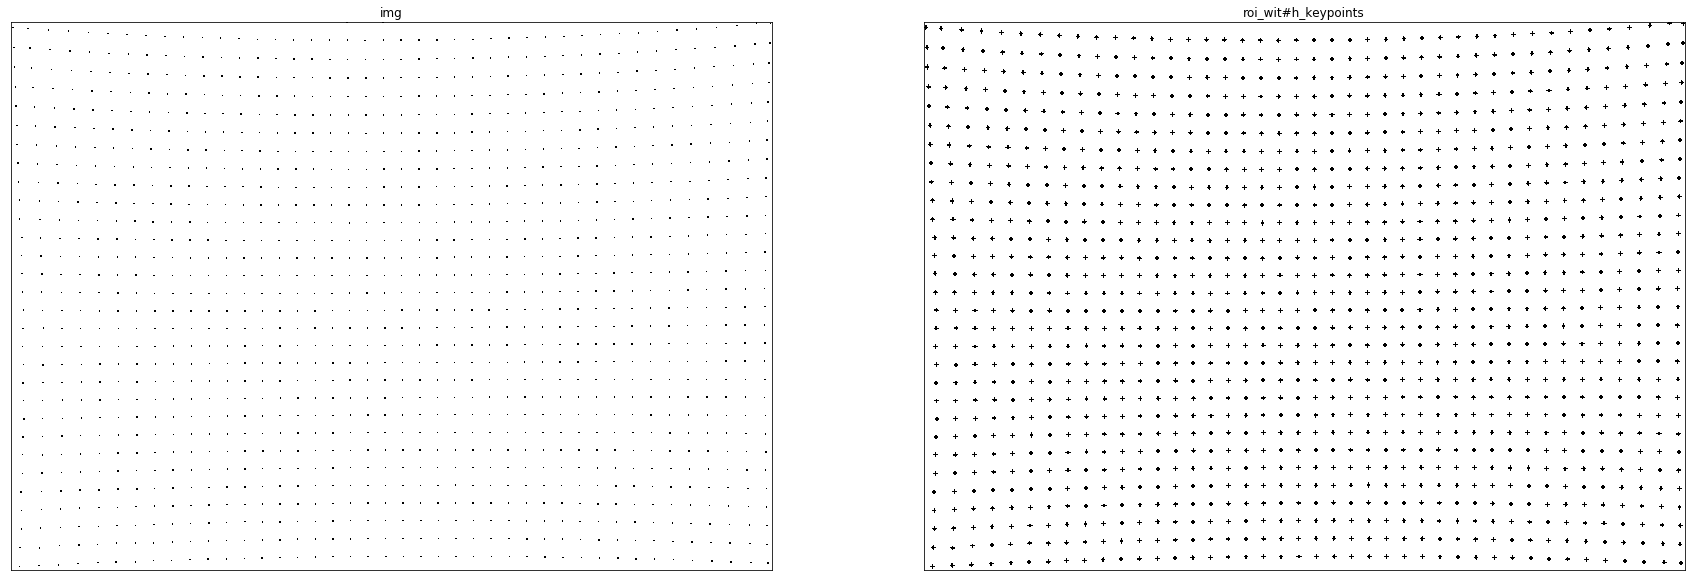

In [322]:
def createDetector_dots():
    blobParams = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    blobParams.minThreshold = 8
    blobParams.maxThreshold = 255

    # Filter by Area.
    blobParams.filterByArea = False
    blobParams.minArea = 20000     # minArea may be adjusted to suit for your experiment
    blobParams.maxArea = 40000   # maxArea may be adjusted to suit for your experiment

    # Filter by Circularity
    blobParams.filterByCircularity = False
    blobParams.minCircularity = 0.1

    # Filter by Convexity
    blobParams.filterByConvexity = True
    blobParams.minConvexity = 0.87

    # Filter by Inertia
    blobParams.filterByInertia = True
    blobParams.minInertiaRatio = 0.01

    blobParams.filterByColor = True
    blobParams.blobColor = 0
    
    # Create the iteration criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)    
    
    return cv2.SimpleBlobDetector_create(blobParams)

def findBLOBs(img):

    detector = createDetector_dots()
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

# img = img_bot_roi
img = dots_roi

keypoints = findBLOBs(img)
print( "[findROI] num keypoints found: ", len(keypoints))

drawSelf = True

kp_found = len(keypoints)

if kp_found > 0:

    blop_pts = np.zeros((kp_found,1,2), dtype='float32')

    if drawSelf:
        #roi_with_keypoints = img.copy()
        roi_with_keypoints = np.ones(img.shape)*255
        for idx, kp in enumerate(keypoints):
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            
            blop_pts[idx,0,0] = x
            blop_pts[idx,0,1] = y

#             if dia < 100 or dia > 250:
#                 print("Skipping #%d: dia = %d" % (idx, dia))
#                 continue

            #print(kp.size)
            #print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

            #cv2.circle(roi_with_keypoints, (x, y), int(dia/2), (0,0,0),2)
            cv2.line(roi_with_keypoints, (x, y-dia), (x, y+dia), (0,0,0), 3)
            cv2.line(roi_with_keypoints, (x-dia, y), (x+dia, y), (0,0,0), 3)
            
    else:
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        roi_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    util.plot_imgs([(img,'img'), (roi_with_keypoints,'roi_with_keypoints')], max_cols = 2, fig_size=15)

In [324]:
blop_pts[0:5]

array([[[   28.,  1832.]],

       [[   94.,  1828.]],

       [[  159.,  1826.]],

       [[  225.,  1822.]],

       [[ 2546.,  1820.]]], dtype=float32)

In [213]:
dot_rows = 2
dot_cols = 3

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((dot_cols*dot_rows,3), np.float32)
print(objp)
objp[:,:2] = np.mgrid[0:dot_rows,0:dot_cols].T.reshape(-1,2)
objp

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.]], dtype=float32)

In [325]:
dot_rows = 30
dot_cols = 42

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp[0:4]

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)

In [208]:
patternSize = (dot_rows, dot_cols)

#flags = cv2.CALIB_CB_ASYMMETRIC_GRID
#flags = cv2.CALIB_CB_SYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING
flags = cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_SYMMETRIC_GRID

retval, centers = cv2.findCirclesGrid(dots_roi, patternSize, None, flags, createDetector_dots())

#     im_with_keypoints_gray = cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2GRAY)
#     retval, corners = cv2.findCirclesGrid(im_with_keypoints, (4,11), None, flags = cv2.CALIB_CB_ASYMMETRIC_GRID)   # Find the circle grid


# If found, add object points, image points (after refining them)
if retval == True:
    print(" > Found it with pattern: (%d, %d)" % (patternSize[0], patternSize[1]))
    
    objpoints.append(objp)
    
    centers2 = cv2.cornerSubPix(dots_roi, centers,(11,11),(-1,-1),criteria)
    imgpoints.append(centers2)

    img2 = dots_roi.copy()
    cv2.drawChessboardCorners(img2, patternSize, centers2, retval);
    
    util.plot_imgs([(img2,'dots_roi')])
else:
    print("Not Found...")

Not Found...


In [333]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((dot_cols*dot_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:dot_rows,0:dot_cols].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

objpoints.append(objp)
imgpoints.append(blop_pts)

ret, mtx_dots, dist_dots, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, dots_roi.shape[::-1],None,None)
mtx_dots


array([[  6.19910130e+03,   0.00000000e+00,   1.26492267e+03],
       [  0.00000000e+00,   6.40126107e+04,   9.10183203e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [5]:
#p = DIF2_circGrid_path
p = DIF2_CB_path
#p = cb_DIF2_path
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
img_equ = cv2.equalizeHist(img)
img_equ = img
rows, cols = img.shape
midX, midY = int(cols/2), int(rows/2)
imgSlice = img_equ[midY+1:rows, 0:cols]
img8 = convert16BitTo8Bit(imgSlice)  

# with open(paths.tmp_dir + '/DIF2_cam_calib.json') as cam_calib_file:
#     cam_calib2 = json.load(cam_calib_file)

mtx2 = mtx_dots
dist2 = dist_dots

h,  w = img8.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx2,dist2,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(img8, mtx2, dist2, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

print("imgSlice - rows: %d, cols: %d" % (imgSlice.shape[0],imgSlice.shape[1]))
print("dst      - rows: %d, cols: %d" % (dst.shape[0],dst.shape[1]))

#adder = cv2.addWeighted(img8,0.5,dst,0.5,0)

util.plot_imgs([(imgSlice,'imgSlice'), (dst,'dst')], max_cols = 2)

NameError: name 'mtx_dots' is not defined

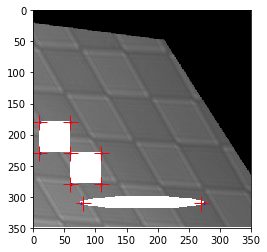

In [6]:
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

p = DIF2_CB_path
#p = cb_DIF2_path
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)


tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(210, 50))
image = warp(img, tform.inverse, output_shape=(350, 350))
rr, cc = ellipse(310, 175, 10, 100)
image[rr, cc] = 1
image[180:230, 10:60] = 1
image[230:280, 60:110] = 1

coords = corner_peaks(corner_harris(image), min_distance=5)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 350, 350, 0))
plt.show()